## 🚨Problem statement: 🚨

<b>To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts <b>for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to <b>reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1065]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomContrast,BatchNormalization,Dense,Conv2D,MaxPooling2D,Dropout,Flatten,Activation,RandomRotation,RandomZoom,RandomContrast,Input,RandomFlip,RandomBrightness
from tensorflow.keras.layers import Rescaling
import random
from sklearn.metrics import classification_report,accuracy_score
from tensorflow.keras.metrics import Precision,Recall,Accuracy
import seaborn as sns

## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [1066]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(r"C:\Users\My PC\Documents\UpGradPGP\DeepLearning-2\MalanomaDetection\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path(r'C:\Users\My PC\Documents\UpGradPGP\DeepLearning-2\MalanomaDetection\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test')

In [1067]:
train_image_path = r"C:\Users\My PC\Documents\UpGradPGP\DeepLearning-2\MalanomaDetection\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train"
test_image_path = r"C:\Users\My PC\Documents\UpGradPGP\DeepLearning-2\MalanomaDetection\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test"

In [1068]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [1069]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [1070]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    seed=51,
    batch_size=batch_size,
    subset="training",
    validation_split = 0.2,
    image_size = (img_height,img_width)) ##todo

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [1071]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    seed=51,
    batch_size=batch_size,
    image_size=(img_height,img_width),
    validation_split=0.2,
    subset='validation'
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [1072]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    labels='inferred',
    seed=51,
    batch_size=batch_size,
    image_size=(img_height,img_width)
)

Found 118 files belonging to 9 classes.


In [1073]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

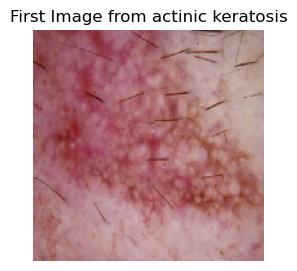

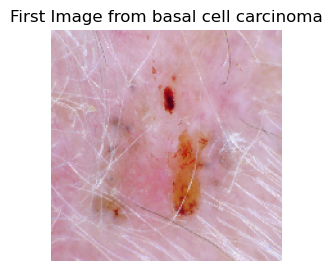

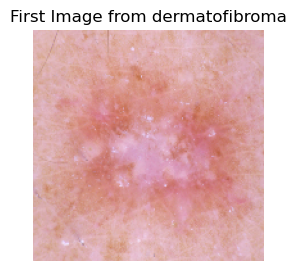

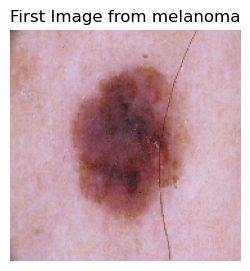

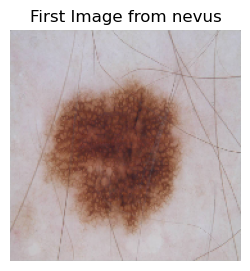

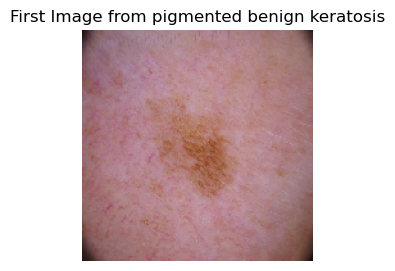

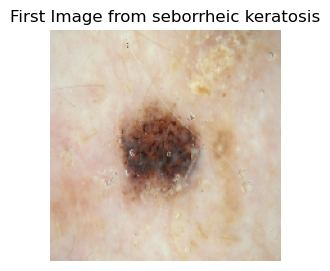

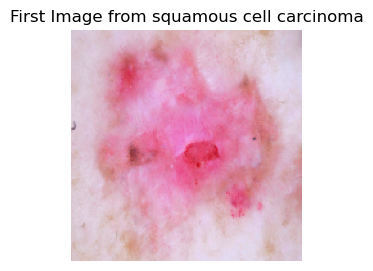

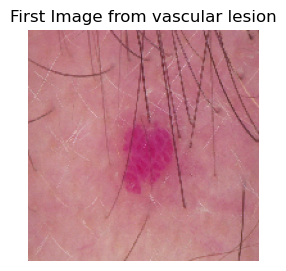

In [1074]:
import os
for subfolder_name in os.listdir(data_dir_train):
    subfolder_path = os.path.join(train_image_path,subfolder_name)
    if os.path.isdir(subfolder_path):
        image_files = os.listdir(subfolder_path)
        first_image_path = os.path.join(subfolder_path, image_files[0]) 
        image = tf.keras.preprocessing.image.load_img(first_image_path, target_size=(180, 180))  # Resize if needed
        image_array = tf.keras.preprocessing.image.img_to_array(image)  # Convert to numpy array

        # Display the first image
        plt.figure(figsize=(3, 3))
        plt.imshow(image_array.astype('uint8'))  # Display the image
        plt.title(f"First Image from {subfolder_name}")
        plt.axis('off')
        plt.show()
        

In [1075]:
os.listdir(subfolder_path)[0]

'ISIC_0024475.jpg'

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [1076]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

#### 🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸First Model Code Starting🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸

In [1077]:
### Your code goes here
rescale_layer = Rescaling(1./255, input_shape=(img_height, img_width, 3))
train_ds = train_ds.map(lambda x, y: (rescale_layer(x), y))
val_ds = val_ds.map(lambda x, y: (rescale_layer(x), y))
test_ds = test_ds.map(lambda x, y: (rescale_layer(x), y))

In [1078]:
input_shape = (180,180,3)

In [1079]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape,activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(9,activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [1080]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [1081]:
# View the summary of all layers
model.summary()

Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_211 (Conv2D)                  │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_202 (MaxPooling2D)     │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_212 (Conv2D)                  │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_203 (MaxPooling2D)     │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_213 (Conv2D)                  │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_204 (MaxPooling2D)     │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_66 (Flatten)                 │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_187 (Dense)                    │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_188 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_189 (Dense)                    │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,655,817 (25.39 MB)

 Trainable params: 6,655,817 (25.39 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [1082]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 292ms/step - accuracy: 0.1863 - loss: 2.3581 - val_accuracy: 0.2327 - val_loss: 1.9897
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 278ms/step - accuracy: 0.2978 - loss: 1.9134 - val_accuracy: 0.3937 - val_loss: 1.7091
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 281ms/step - accuracy: 0.3879 - loss: 1.7656 - val_accuracy: 0.3110 - val_loss: 1.8209
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 284ms/step - accuracy: 0.4494 - loss: 1.5790 - val_accuracy: 0.4743 - val_loss: 1.5735
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 291ms/step - accuracy: 0.4742 - loss: 1.4945 - val_accuracy: 0.4541 - val_loss: 1.5739
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 286ms/step - accuracy: 0.5083 - loss: 1.4050 - val_accuracy: 0.5078 - val_loss: 1.3968
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 278ms/step - accuracy: 0.5463 - loss: 1.3163 - val_accuracy: 0.5101 - val_loss: 1.4198
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 281ms/step - accuracy: 0.5713 - loss: 1.1745 - val_accu

### Visualizing training results

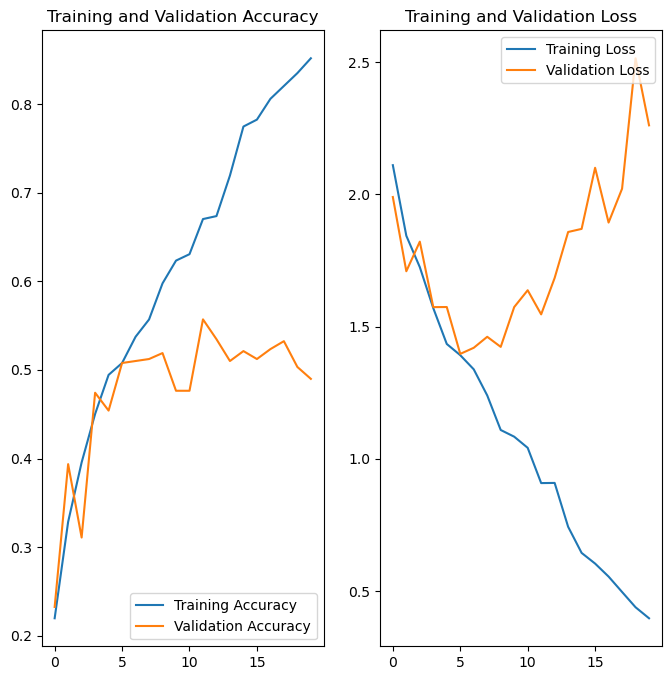

In [1083]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

In [1084]:
y_predicted = model.predict(val_ds)
y_predicted_labels = np.argmax(y_predicted,axis=1) ## Labelling the val_ds

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


In [1085]:
y=[]
for images, labels in val_ds:  # Convert tensors to numpy arrays
    y.append(labels.numpy())
y_actual = np.concatenate(y, axis=0)   ## Extracting the actual values

In [1086]:
print(classification_report(y_actual,y_predicted_labels))

              precision    recall  f1-score   support

           0       0.08      0.07      0.08        27
           1       0.54      0.59      0.56        74
           2       0.29      0.10      0.14        21
           3       0.57      0.59      0.58        94
           4       0.45      0.34      0.39        62
           5       0.53      0.74      0.62        97
           6       0.00      0.00      0.00        14
           7       0.27      0.23      0.25        35
           8       0.83      0.65      0.73        23

    accuracy                           0.49       447
   macro avg       0.40      0.37      0.37       447
weighted avg       0.47      0.49      0.47       447



In [1087]:
accuracy_score(y_actual,y_predicted_labels)

0.4899328859060403

### Write your findings here

<b> From the above architecture , we can see that on the train data set , the accuracy is high but it is low on the validation which means there is a clear scenario of overfitting

* Train accuracy - 0.85
* Validation accuracy - 0.49

#### 🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸 First Model Code Starting Code Ends 🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸

#### 🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸 Second Code with dropouts🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸

### Todo:
### Create the model, compile and train the model


#### Augmentations Applied are:
* RandomFlip(mode="horizontal_and_vertical")
#### Other additions in this architecture are 5 Dropout layers
<b> 
Batch normalization helps the network converge to an optimal solution faster, which results in faster training time but i have not used it as the code was fast even without this.s

In [1088]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    seed=51,
    batch_size=batch_size,
    subset="training",
    validation_split = 0.2,
    image_size = (img_height,img_width)) ##todo


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    seed=51,
    batch_size=batch_size,
    image_size=(img_height,img_width),
    validation_split=0.2,
    subset='validation'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    labels='inferred',
    seed=51,
    batch_size=batch_size,
    image_size=(img_height,img_width)
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Found 118 files belonging to 9 classes.


In [1089]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Compiling the model

In [1090]:
model = Sequential()

model.add(Input(shape=(180,180,3))) 
model.add(RandomFlip(mode="horizontal_and_vertical")),
model.add(Rescaling(1./255)),

model.add(Conv2D(32, (3, 3), input_shape=(180,180,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())


model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(9,activation='softmax'))

C:\anaconda24\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [1091]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [1092]:
model.summary()

Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_16 (RandomFlip)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_51 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_214 (Conv2D)                  │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_205 (MaxPooling2D)     │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_203 (Dropout)                │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_215 (Conv2D)                  │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_206 (MaxPooling2D)     │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_204 (Dropout)                │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_216 (Conv2D)                  │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_207 (MaxPooling2D)     │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_205 (Dropout)                │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_67 (Flatten)                 │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_190 (Dense)                    │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_206 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_191 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_207 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_192 (Dense)                    │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,655,817 (25.39 MB)

 Trainable params: 6,655,817 (25.39 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [1093]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 355ms/step - accuracy: 0.1819 - loss: 2.9153 - val_accuracy: 0.2707 - val_loss: 2.0898
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 334ms/step - accuracy: 0.2041 - loss: 2.0601 - val_accuracy: 0.3535 - val_loss: 2.0654
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 334ms/step - accuracy: 0.2636 - loss: 1.9733 - val_accuracy: 0.3356 - val_loss: 1.9019
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 335ms/step - accuracy: 0.2988 - loss: 1.8692 - val_accuracy: 0.3490 - val_loss: 1.7718
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 330ms/step - accuracy: 0.3893 - loss: 1.7573 - val_accuracy: 0.3893 - val_loss: 1.7609
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 342ms/step - accuracy: 0.3961 - loss: 1.6971 - val_accuracy: 0.4228 - val_loss: 1.6458
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 342ms/step - accuracy: 0.4226 - loss: 1.5909 - val_accuracy: 0.4452 - val_loss: 1.5842
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 338ms/step - accuracy: 0.4530 - loss: 1.5026 - val_accu

### Visualizing the results

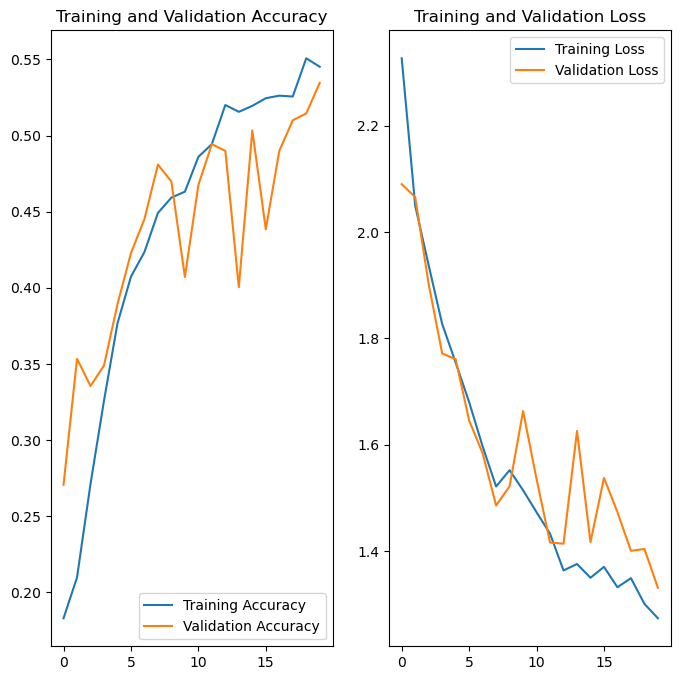

In [1094]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [1095]:
Final_accuracy = pd.DataFrame(history.history)
print("The final Accuracy on Train and Validation set is as follows : \n")
pd.DataFrame(Final_accuracy.iloc[19,:]).T

The final Accuracy on Train and Validation set is as follows : 



,accuracy,loss,val_accuracy,val_loss
19,0.545201,1.27408,0.534676,1.331387


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

In [1096]:
predictions = model.predict(val_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


In [1097]:
y_pred = np.argmax(predictions,axis=1)

In [1098]:
y=[]
for image,labels in val_ds:
    y.extend(labels.numpy())


In [1099]:
print(classification_report(y,y_pred,zero_division=0))

              precision    recall  f1-score   support

           0       0.17      0.04      0.06        27
           1       0.51      0.65      0.57        74
           2       0.00      0.00      0.00        21
           3       0.68      0.65      0.66        94
           4       0.51      0.50      0.50        62
           5       0.48      0.79      0.60        97
           6       0.00      0.00      0.00        14
           7       0.23      0.09      0.12        35
           8       0.86      0.78      0.82        23

    accuracy                           0.53       447
   macro avg       0.38      0.39      0.37       447
weighted avg       0.47      0.53      0.49       447



<b> From the above architecture , we can see that on the train data set and the validation the values are low which means there is a clear scenario of underfitting but there isn't a heavy bias.
* Train accuracy - 0.54
* Validation accuracy 0.53

#### 🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸 Third Code with Augmentor and new generated samples🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [1100]:
## Your code goes here.
disease_name=[]
count=[]
for subfolder_name in os.listdir(data_dir_train):
    subfolder_path = os.path.join(train_image_path,subfolder_name)
    if os.path.isdir(subfolder_path):
        image_files = os.listdir(subfolder_path)
        disease_name.append(subfolder_name)
        count.append(len(image_files))
        
        

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


In [1101]:
train_data_spread = pd.DataFrame(index=disease_name,data=count,columns=['No of Images'])
train_data_spread=train_data_spread.sort_values(by='No of Images')

                            No of Images
seborrheic keratosis                  77
dermatofibroma                        95
actinic keratosis                    114
vascular lesion                      139
squamous cell carcinoma              181
nevus                                357
basal cell carcinoma                 376
melanoma                             438
pigmented benign keratosis           462


<Axes: >

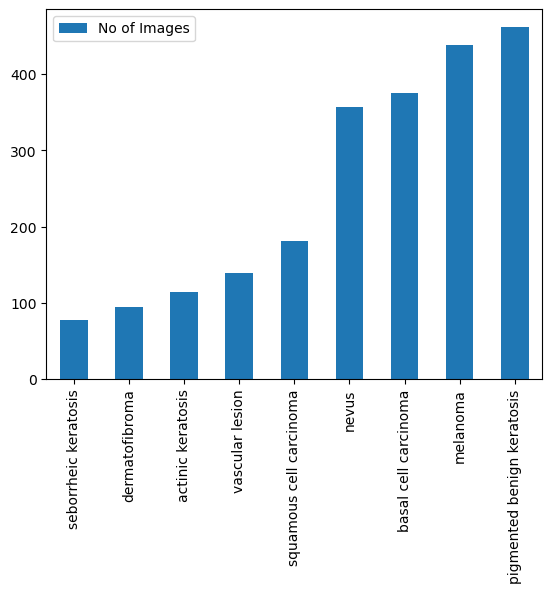

In [1102]:
print(train_data_spread)
train_data_spread.plot(kind='bar')

* #### pigmented benign keratosis has the most number of images with 462 data points
* #### seborrheic keratosis has the least number of values with 77 data points

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [1103]:
import Augmentor

In [1104]:
for i in class_names:
    data = Augmentor.Pipeline(source_directory=os.path.join(train_image_path,i),save_format='JPEG')
    data.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10) #rotate the image
    data.sample(500)

Initialised with 114 image(s) found.
Output directory set to C:\Users\My PC\Documents\UpGradPGP\DeepLearning-2\MalanomaDetection\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28C62770200>: 100%|█| 500/500 [00:02<00:00, 190.26 Samples


Initialised with 376 image(s) found.
Output directory set to C:\Users\My PC\Documents\UpGradPGP\DeepLearning-2\MalanomaDetection\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x289FC3757F0>: 100%|█| 500/500 [00:02<00:00, 179.99 Samples


Initialised with 95 image(s) found.
Output directory set to C:\Users\My PC\Documents\UpGradPGP\DeepLearning-2\MalanomaDetection\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28C65128E60>: 100%|█| 500/500 [00:02<00:00, 177.21 Samples


Initialised with 438 image(s) found.
Output directory set to C:\Users\My PC\Documents\UpGradPGP\DeepLearning-2\MalanomaDetection\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x28C6284B3E0>: 100%|█| 500/500 [00:15<00:00, 33.29 Samples


Initialised with 357 image(s) found.
Output directory set to C:\Users\My PC\Documents\UpGradPGP\DeepLearning-2\MalanomaDetection\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x28C6562CB90>: 100%|█| 500/500 [00:12<0


Initialised with 462 image(s) found.
Output directory set to C:\Users\My PC\Documents\UpGradPGP\DeepLearning-2\MalanomaDetection\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x28C3AA67EF0>: 100%|█| 500/500 [00:02<00:


Initialised with 77 image(s) found.
Output directory set to C:\Users\My PC\Documents\UpGradPGP\DeepLearning-2\MalanomaDetection\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x28C585A3B90>: 100%|█| 500/500 [00:07<00:00, 68.09 Samples


Initialised with 181 image(s) found.
Output directory set to C:\Users\My PC\Documents\UpGradPGP\DeepLearning-2\MalanomaDetection\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x28C6567B380>: 100%|█| 500/500 [00:03<00:


Initialised with 139 image(s) found.
Output directory set to C:\Users\My PC\Documents\UpGradPGP\DeepLearning-2\MalanomaDetection\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28C3A9430E0>: 100%|█| 500/500 [00:03<00:00, 159.57 Samples


In [1105]:
from pathlib import Path

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [1106]:
data_dir_train=Path(data_dir_train)
image_count_train = len(list(data_dir_train.glob('*/output/*.JPEG')))
print(image_count_train)


4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [1107]:
from glob import glob

In [1108]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.JPEG'))]
path_list

['C:\\Users\\My PC\\Documents\\UpGradPGP\\DeepLearning-2\\MalanomaDetection\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_18cc9765-2240-4fd4-a942-e10900f2a942.JPEG',
 'C:\\Users\\My PC\\Documents\\UpGradPGP\\DeepLearning-2\\MalanomaDetection\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_4d9d3360-ec7b-4e14-a327-3a7e676fcc4e.JPEG',
 'C:\\Users\\My PC\\Documents\\UpGradPGP\\DeepLearning-2\\MalanomaDetection\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_93001a9b-384b-4944-baf1-803a3116a672.JPEG',
 'C:\\Users\\My PC\\Documents\\UpGradPGP\\DeepLearning-2\\MalanomaDetection\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\act

In [1109]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.JPEG'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [1110]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [1111]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [1112]:
df2['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [1113]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [1114]:
data_dir_train=r"C:\Users\My PC\Documents\UpGradPGP\DeepLearning-2\MalanomaDetection\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size= (img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [1115]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [1116]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [1117]:
## your code goes here
model = Sequential()

model.add(Input(shape=(180,180,3)))
model.add(Rescaling(1./255)),


model.add(Conv2D(32, (3, 3), input_shape=(180,180,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())


model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dense(9,activation='softmax'))

C:\anaconda24\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [1118]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [1119]:
model.summary()

Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_52 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_217 (Conv2D)                  │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_208 (MaxPooling2D)     │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_208 (Dropout)                │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_218 (Conv2D)                  │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_209 (MaxPooling2D)     │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_209 (Dropout)                │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_219 (Conv2D)                  │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_210 (MaxPooling2D)     │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_210 (Dropout)                │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_68 (Flatten)                 │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_193 (Dense)                    │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_211 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_194 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_195 (Dense)                    │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,655,817 (25.39 MB)

 Trainable params: 6,655,817 (25.39 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:**  Train your model

In [1120]:
epochs = 50
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 93s 385ms/step - accuracy: 0.1354 - loss: 2.3215 - val_accuracy: 0.1403 - val_loss: 2.1870
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 57s 340ms/step - accuracy: 0.1672 - loss: 2.1330 - val_accuracy: 0.2227 - val_loss: 1.9711
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 57s 338ms/step - accuracy: 0.2347 - loss: 1.9720 - val_accuracy: 0.2903 - val_loss: 1.8233
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 56s 334ms/step - accuracy: 0.3029 - loss: 1.7780 - val_accuracy: 0.3385 - val_loss: 1.6770
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 364ms/step - accuracy: 0.3577 - loss: 1.6516 - val_accuracy: 0.3831 - val_loss: 1.5627
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 58s 346ms/step - accuracy: 0.4024 - loss: 1.5139 - val_accuracy: 0.4692 - val_loss: 1.3925
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 328ms/step - accuracy: 0.4593 - loss: 1.4089 - val_accuracy: 0.4959 - val_loss: 1.3422
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 62s 365ms/step - accuracy: 0.4959 - loss: 1

#### **Todo:**  Visualize the model results

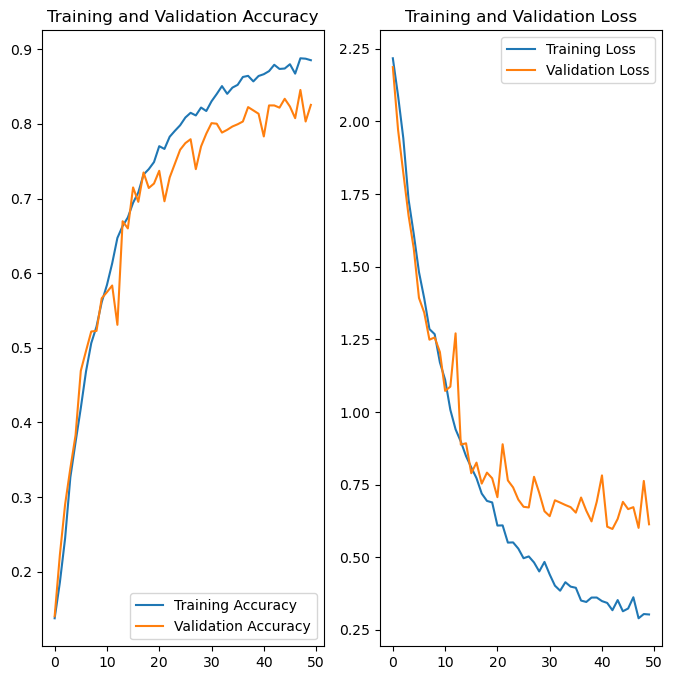

In [1121]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [1122]:
predictions = model.predict(val_ds)
y_val_pred = np.argmax(predictions,axis=1) 

43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step


In [1123]:
y_val_actual=[]
for image,labels in val_ds:
    y_val_actual.extend(labels.numpy())
    

In [1124]:
print(classification_report(y_val_actual,y_val_pred))

              precision    recall  f1-score   support

           0       0.74      0.81      0.77       121
           1       0.86      0.77      0.81       155
           2       0.92      0.94      0.93       140
           3       0.75      0.72      0.74       183
           4       0.80      0.73      0.77       180
           5       0.78      0.89      0.83       189
           6       0.77      0.73      0.75       121
           7       0.88      0.88      0.88       112
           8       0.96      0.99      0.98       146

    accuracy                           0.83      1347
   macro avg       0.83      0.83      0.83      1347
weighted avg       0.83      0.83      0.82      1347



#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



<b> The class rebalance has significantly improved our score by over 25% on both our train and test models and the dropout layer added has also removed the bias

#### 🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸Third Code with Augmentor and new generated samples ends🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸🔸

## 📌 <b>SUMMARY 

<b>1. After loading the data set , we have used a simple architecture with no dropout layer and ran for 20 Epochs. 

* Train accuracy - 0.85

* Validation accuracy - 0.49
  
<b>We see that there is a severe overfit on the training data<b>

<b>2. In the second model , we have included few droup out layers and here are the stats:

* Train accuracy - 0.54

* Validation accuracy - 0.53

<b> We see that the overall fit of the model in validation has increased but significantly decreased on test and now the model is Underfitting both Train and Validation

<b>3. In the third and final model , we have included few drop out layers and used augmentor to add in 500 additional datapoints per class with slight rotation

* Train accuracy - 0.88

* Validation accuracy - 0.83

<b> We see that the overall fit of the model in validation and training has increased and has improved the accuracy as well. Though it is not the best performing model. This is a good place to start. With more data points and epochs , the value can improve significantly.